BÀI THỰC HÀNH PHẦN MULTI-CLASS SUPPORT VECTOR MACHINE
Ví dụ 1. Chúng ta thực hiện với thư viện Sci-kit learn. Mã lệnh tương tự SoftMargin, chỉ số nhãn (labels) lớn hơn
2. Ta thực hiện ví dụ với dữ liệu nhân tạo dưới đây:

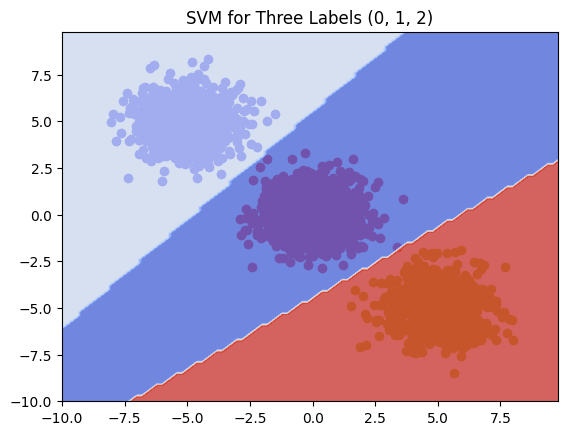

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
N = 1000 # Number of samples
# Create synthetic dataset
X1 = np.random.normal(loc=0, scale=1, size=(N, 2))
Y1 = 0 * np.ones(shape=(1000,)) # LABEL = 0
X2 = np.random.normal(loc=[-5, 5], scale=1, size=(N, 2))
Y2 = 1 * np.ones(shape=(1000,)) # LABEL = 1
X3 = np.random.normal(loc=[5, -5], scale=1, size=(N, 2))
Y3 = 2 * np.ones(shape=(1000,)) # LABEL = 2
# Create stacked dataset
X = np.vstack((X1, X2, X3))
Y = np.hstack((Y1, Y2, Y3))
# TRAIN SVM LEARNING ALGORITHM
clf = SVC(kernel='linear')
clf = clf.fit(X, Y)
# create decision boundary plot
xx, yy = np.meshgrid(
np.arange(-10, 10, 0.2),
np.arange(-10, 10, 0.2))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# PLOT EVERYTHING
plt.scatter(X1[:,0], X1[:,1], color='r')
plt.scatter(X2[:,0], X2[:,1], color='b')
plt.scatter(X3[:,0], X3[:,1], color='y')
plt.contourf(xx,yy,Z,cmap=plt.cm.coolwarm, alpha=0.8)
plt.title("SVM for Three Labels (0, 1, 2)")
plt.show()

# Bài tập tự thực hành 1: 
Hãy sử dụng đoạn code trên, tiến hành huấn luyện với 1000 ảnh từ tập ảnh chữ số viết tay và thực hiện dự đoán phân loại cho 500 ảnh khác.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
digits = datasets.load_digits()
X, Y = digits.data, digits.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3333, random_state=42)

In [3]:
clf = SVC(kernel='linear')
clf = clf.fit(X_train, Y_train)

In [4]:
Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9766277128547579
Confusion Matrix:
[[55  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  2  0]
 [ 0  0 52  0  0  0  0  0  0  0]
 [ 0  0  1 55  0  1  0  0  0  0]
 [ 0  0  0  0 64  0  0  0  0  0]
 [ 0  0  0  1  0 70  1  0  0  1]
 [ 1  0  0  0  0  0 56  0  0  0]
 [ 0  0  0  0  0  0  0 61  0  1]
 [ 0  2  0  0  0  1  0  0 50  0]
 [ 0  0  0  1  0  0  0  0  1 67]]


Ví dụ 2: Chúng ta tạo một bộ dữ liệu có 25000 mẫu (N=25000), mỗi mẫu có 3000 chiều (d=3000) được phân vào
10 lớp (C = 10), dữ liệu được tạo và phân lớp một cách ngẫu nhiên.
Tiếp theo chúng ta xây dựng các phương thức cần thiết cho phương pháp Multi-Class Vector Machine và tiến hành
thực hiện phân lớp trên bộ dữ liệu nói trên. Trong chương trình này, chúng ta cài đặt phương pháp tiếp cận theo
hướng Hingloss, tức là đưa về bài toán tối ưu toàn cục. Các bạn thực hành để kiểm nghiệm.
Trước hết ta gọi các thư viện cần thiết và tạo dữ liệu – Dữ liệu training sẽ là (X, y):

In [1]:
import numpy as np

from random import shuffle
N, C, d = 25000, 10, 3000
reg = .05
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

In [3]:
print(len(W))
print(len(X))
print(len(y))

3000
3000
25000


Tiếp theo chúng ta xây dựng phương thức tính hàm Loss (tổn thất) và đạo hàm (Grad) với dữ liệu hiện tại

In [3]:
# method to compute loss function and its gradient
# here vectorization was used to speed up
def svm_loss_vectorized(W, X, y, reg):
    d, C = W.shape
    _, N = X.shape
    loss = 0
    dW = np.zeros_like(W)
    Z = W.T.dot(X)
    correct_class_score = np.choose(y, Z).reshape(N,1).T
    margins = np.maximum(0, Z - correct_class_score + 1)
    margins[y, np.arange(margins.shape[1])] = 0
    # Loss function
    loss = np.sum(margins, axis = (0, 1))
    loss /= N
    loss += 0.5 * reg * np.sum(W * W)
    F = (margins > 0).astype(int)
    F[y, np.arange(F.shape[1])] = np.sum(-F, axis = 0)
    # Gradient
    dW = X.dot(F.T)/N + reg*W
    return loss, dW

Xây dựng phương pháp lặp Mini Batch Gradient Descent sử dụng hàm tính Gradient và Loss như trên

In [4]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=.1,batch_size = 100, num_iters = 1000, print_every = 100):
    W = Winit
    loss_history = np.zeros((num_iters))
    for it in range(num_iters):
        # randomly pick a batch of X
        idx = np.random.choice(X.shape[1], batch_size)
        X_batch = X[:, idx]
        y_batch = y[idx]
        loss_history[it], dW = \
        svm_loss_vectorized(W, X_batch, y_batch, reg)
        W -= lr*dW
        if it % print_every == 1:
            print ('it %d/%d, loss = %f' %(it, num_iters, loss_history[it]))
    return W, loss_history

Chạy thử và in ra biến thiên của Loss function, sau đó vẽ lên đồ thị để quan sát:

it 1/1000, loss = 1018.584444
it 101/1000, loss = 389.039130
it 201/1000, loss = 118.077086
it 301/1000, loss = 59.243228
it 401/1000, loss = 31.850611
it 501/1000, loss = 32.770103
it 601/1000, loss = 28.040828
it 701/1000, loss = 29.784679
it 801/1000, loss = 29.268615
it 901/1000, loss = 31.244628


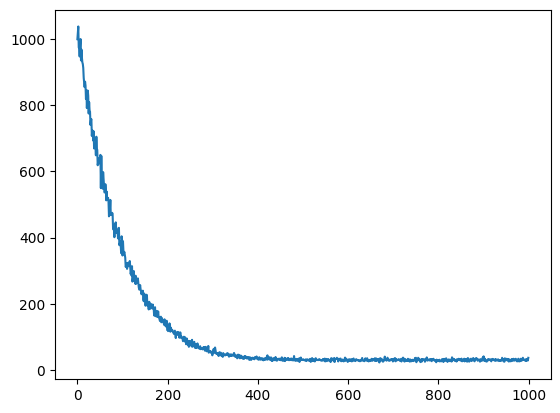

In [5]:
W, loss_history = multiclass_svm_GD(X, y, W, reg)
import matplotlib.pyplot as plt
# plot loss as a function of iteration
plt.plot(loss_history)
plt.show()

# Bài tập thực hành 2:
Hãy tạo tập dữ liệu chỉ có 02 chiều, với các phân loại có phân bố chuẩn (xem lại ví dụ ở các phần trước), số mẫu mỗi loại là 200. Chạy lại chương trình trên với dữ liệu mới, sau đó hiển thị trực quan để quan sát kết quả.

In [5]:
np.random.seed(42)
N = 200
X1 = np.random.normal(loc=[2, 2], scale=1, size=(N, 2))
Y1 = 0 * np.ones(shape=(N,))

X2 = np.random.normal(loc=[-2, -2], scale=1, size=(N, 2))
Y2 = 1 * np.ones(shape=(N,))

X = np.vstack((X1, X2))
Y = np.hstack((Y1, Y2))

In [6]:
clf = SVC(kernel='linear')
clf = clf.fit(X, Y)

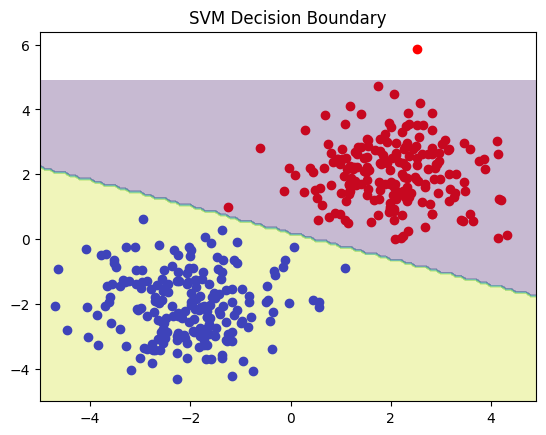

In [7]:
xx, yy = np.meshgrid(
    np.arange(-5, 5, 0.1),
    np.arange(-5, 5, 0.1)
)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.scatter(X1[:, 0], X1[:, 1], color='r')
plt.scatter(X2[:, 0], X2[:, 1], color='b')
plt.contourf(xx, yy, Z, alpha=0.3)
plt.title("SVM Decision Boundary")
plt.show()

# Bài tập thực hành 3:
Xem lại các bài ví dụ phần trước, sử dụng bộ trọng số W đã tính được và dự đoán các phân lớp y ứng với dữ liệu X
trên chính tập dữ liệu ngẫu nhiên vừa tạo. Đưa ra độ chính xác Accuracy và ma trận nhầm lẫn Confusion Matrix.

In [8]:
Y_pred = clf.predict(X)

accuracy = accuracy_score(Y, Y_pred)
conf_matrix = confusion_matrix(Y, Y_pred)

In [9]:
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 1.0
Confusion Matrix:
[[200   0]
 [  0 200]]


# Bài tập thực hành 4:
Hãy sửa phần đọc dữ liệu trong Ví dụ 1 ở trên, sau đó áp dụng cho phần phân loại chữ số viết tay với dữ liệu được
cho trong bài tập phần Multinomial Logistic Regression (xem lại link sau đây để tìm hiểu cách đọc dữ liệu:
https://classroom.google.com/u/1/c/MzkzNzg2MDI5MDcz/m/NDIxODAwNjQ5Njk5/details ). Sau đó, hãy áp
dụng phương pháp Multi-Class SVM với các đoạn lệnh nói trên để phân loại các chữ số viết tay đọc được.
Đưa ra độ chính xác, ma trận nhầm lẫn như với Bài tâp thực hành 3.

In [10]:
import os
import numpy as np

# set names to the paths because they're too long
data_path = 'C:/Users/Admin/Desktop/ML/week4/'

# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')

# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [11]:
# Xây dựng phương thức đọc dữ liệu từ tệp gzip, giải nén và đưa về định dạng là một dãy ảnh (một dãy ma trận nguyên)

def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip # to decompress gz (zip) file
    
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    
    labels = np.zeros((real_num)).astype(np.int64)
    
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        
        images = images[rand_id, :]
        labels = labels[rand_id,]
        
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [12]:
# Xây dựng phương thức đọc dữ liệu từ tệp gzip, giải nén và đưa về định dạng là một dãy ảnh (một dãy ma trận nguyên)

def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip # to decompress gz (zip) file
    
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size * image_size)
    
    
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    
    labels = np.zeros((real_num)).astype(np.int64)
    
    # rearrange to correspond the images and labels
    for i in range(real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        
        images = images[rand_id, :]
        labels = labels[rand_id,]
        
    # change images data to type of vector 28x28 dimentional
    # images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [13]:
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 60000, shuffle=True)

test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000, _is=False, shuffle=True)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_31016\600803793.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(60000, 784) (60000,)
(10000, 784) (10000,)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import svm
from sklearn.metrics import confusion_matrix

# optimal hyperparameters
best_C = 10
best_gamma = 1e-06

In [15]:
svm_final = svm.SVC(kernel='rbf', C=best_C, gamma=best_gamma)

# fit
svm_final.fit(train_images, train_labels)

SVC(C=10, gamma=1e-06)

In [16]:
pred = svm_final.predict(test_images)

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import  precision_score, recall_score, classification_report

precision = precision_score(test_labels, pred, average='weighted')
recall = recall_score(test_labels, pred, average='weighted')



print(f"Accuracy score: {accuracy_score(test_labels, pred)}")
print(f"Precision Score: {precision:.2f}")
print(f"Recall Score: {recall:.2f}")

print(classification_report(test_labels, pred))

Accuracy score: 0.9745
Precision Score: 0.97
Recall Score: 0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       950
           1       0.99      0.99      0.99      1138
           2       0.94      0.98      0.96      1057
           3       0.97      0.98      0.97       972
           4       0.98      0.99      0.99      1013
           5       0.98      0.97      0.97       893
           6       0.99      0.97      0.98       959
           7       0.98      0.96      0.97      1028
           8       0.95      0.98      0.96       981
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



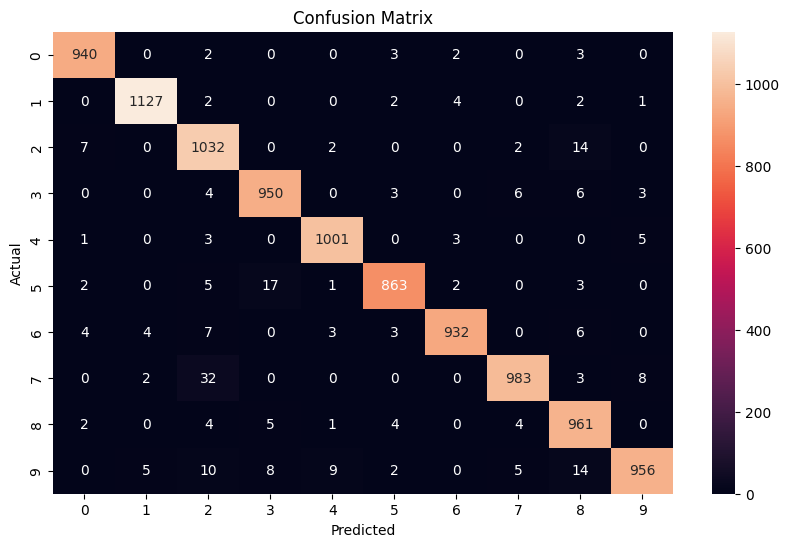

In [18]:
cm = confusion_matrix(test_labels, pred)


plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()